## Random Forest
This notebook fits a Random Forest model to the Scania Trucks Air Pressure System (APS) predictive maintenance dataset, obtained from [UCI's data repository](https://archive.ics.uci.edu/ml/datasets/APS+Failure+at+Scania+Trucks). 

In the Logistic Regression & Naive Bayes notebooks, grid searches were used for hyperparameter tuning. However, significantly more computational resources are required to fit a Random Forest model. Thus, this notebook will use Bayesian Optimization in lieu of grid search.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from hyperopt import fmin, tpe, hp, Trials
from hyperopt.early_stop import no_progress_loss
from collections import defaultdict
from functools import partial

from sklearn.impute import SimpleImputer
from sklearn.metrics import auc, roc_curve, precision_recall_curve, make_scorer, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

sns.set()

### Load Data

In [2]:
df_train = pd.read_csv(r'./data/aps_failure_training_set_data_only.csv')

In [3]:
# df --> X_train & y_train
X_train = df_train.drop('class', axis=1)
y_train = df_train['class']

### Bayesian Optimization

In [4]:
def calc_misclassification_cost(y, y_pred):
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    return 10*fp + 500*fn


misclassification_cost = make_scorer(
    calc_misclassification_cost,
    greater_is_better=False,
    needs_proba=False,
    needs_threshold=False
)

In [5]:
class LogFile:
    def __init__(self, file_path):
        self.i = 1
        self.file_path = file_path
        pass

    def write_log_file(self, cv_mean_cost, params, params_skl):
        
        # Initialize
        dd = defaultdict(list)

        # Combine hyperopt params & skl params
        for d in (params, params_skl):
            for key, value in d.items():
                dd[key].append(value)

        # Create df & add iteration / cost
        df = pd.DataFrame(dd, index=['hyperopt', 'sklearn'])
        df['Iteration'] = self.i
        df['cv_mean_cost'] = cv_mean_cost

        # Reorder & append to log file
        df = df[['Iteration', 'cv_mean_cost', *dd.keys()]]

        # Write header
        if self.i == 1:
            df.to_csv(self.file_path, mode='w', header=True)
        else:
            df.to_csv(self.file_path, mode='a', header=False)

        # Increase iteration number
        self.i += 1

        pass

In [5]:
def create_sklearn_pipeline(params, fill_na, sampling):
    steps = []

    # Impute
    if type(fill_na) == int:
        steps.append(('impute', SimpleImputer(strategy='constant', fill_value=fill_na)))
    else:
        steps.append(('impute', SimpleImputer(strategy=fill_na)))

    # SMOTE
    if sampling == 'smote':
        steps.append(('smote', SMOTE(random_state=1)))
        steps.append(('rf_clf', RandomForestClassifier(random_state=1, n_estimators=150, n_jobs=-1, **params)))
        pipe = imbPipeline(steps=steps)

    else:
        steps.append(('rf_clf', RandomForestClassifier(random_state=1, n_estimators=150, n_jobs=-1, **params)))
        pipe = Pipeline(steps=steps)

    return pipe


def objective(params, LogFile):

    # Initialize
    params_rf = {
        'class_weight': params['class_weight'],
        'criterion': params['criterion'],
        'max_depth': None if params['max_depth'] == None else int(params['max_depth']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_split']),
        'max_features': params['max_features'],
        'max_leaf_nodes': None if params['max_leaf_nodes'] == None else int(params['max_leaf_nodes'])
    }

    # Create pipeline
    pipe = create_sklearn_pipeline(params_rf, params['fill_na'], params['sampling'])

    # Fit data & calculate CV score
    scores = cross_val_score(pipe, cv=5, X=X_train, y=y_train, scoring=misclassification_cost, n_jobs=-1)
    cv_mean_cost = -scores.mean()

    # Write params & results to log
    LogFile.write_log_file(cv_mean_cost, params, params_rf)

    return cv_mean_cost

In [7]:
%%time

space = {
    'fill_na': hp.choice('fill_na', [0, -1, -10_000, 'most_frequent']),
    'sampling': hp.choice('sampling', [None, 'smote']),
    'class_weight': hp.choice('class_weight', [None, 'balanced', 'balanced_subsample']),
    'criterion': hp.choice('criterion', ['gini', 'entropy', 'log_loss']),
    'max_depth': hp.choice('max_depth', [None, hp.quniform('max_depth_int', 2, 1000, 2)]),
    'min_samples_split': hp.uniform('min_samples_split', 2, 500),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 2, 500),
    'max_features': hp.choice('max_features', ['sqrt', 'log2', None]),
    'max_leaf_nodes': hp.choice('max_leaf_nodes', [None, hp.uniform('max_leaf_nodes_int', 100, 500)])
}

# Set up log file
log_file = LogFile(r'./logs/log_rf_bayes_opt.csv')

# Set up objective function & pass log file
f_objective = partial(objective, LogFile=log_file)

# Bayesian Optimization
trials = Trials()
best = fmin(fn=f_objective, space=space, early_stop_fn=no_progress_loss(40), max_evals=300, rstate=np.random.default_rng(1), algo=tpe.suggest, trials=trials)

 27%|██▋       | 80/300 [2:31:41<6:57:09, 113.77s/trial, best loss: 9142.0] 
CPU times: user 5.88 s, sys: 2.34 s, total: 8.22 s
Wall time: 2h 31min 41s


In [8]:
best

{'class_weight': 2,
 'criterion': 2,
 'fill_na': 0,
 'max_depth': 1,
 'max_depth_int': 926.0,
 'max_features': 2,
 'max_leaf_nodes': 1,
 'max_leaf_nodes_int': 160.02443333483498,
 'min_samples_leaf': 21.472890321167622,
 'min_samples_split': 133.56709435734882,
 'sampling': 0}

In [7]:
log_df = pd.read_csv(r'./logs/log_rf_bayes_opt.csv')
log_df.head()

,Unnamed: 0,Iteration,cv_mean_cost,class_weight,criterion,fill_na,max_depth,max_features,max_leaf_nodes,min_samples_leaf,min_samples_split,sampling
0,hyperopt,1,10090.0,balanced,log_loss,-1,NaN,sqrt,190.596769,278.436732,174.454308,NaN
1,sklearn,1,10090.0,balanced,log_loss,-1,NaN,sqrt,190.000000,174.000000,174.000000,NaN
2,hyperopt,2,10160.0,balanced_subsample,log_loss,0,992.0,NaN,106.773527,379.293074,345.171999,NaN
3,sklearn,2,10160.0,balanced_subsample,log_loss,0,992.0,NaN,106.000000,345.000000,345.000000,NaN
4,hyperopt,3,10638.0,balanced_subsample,entropy,most_frequent,106.0,NaN,445.517986,444.490862,437.961795,NaN


In [31]:
log_df.sort_values(by='cv_mean_cost').head()

,Unnamed: 0,Iteration,cv_mean_cost,class_weight,criterion,fill_na,max_depth,max_features,max_leaf_nodes,min_samples_leaf,min_samples_split,sampling
79,sklearn,40,9142.0,balanced_subsample,log_loss,0,926.0,NaN,160.000000,133.000000,133.000000,NaN
78,hyperopt,40,9142.0,balanced_subsample,log_loss,0,926.0,NaN,160.024433,21.472890,133.567094,NaN
80,hyperopt,41,9370.0,balanced_subsample,log_loss,most_frequent,950.0,NaN,145.032613,29.599696,139.585983,NaN
81,sklearn,41,9370.0,balanced_subsample,log_loss,most_frequent,950.0,NaN,145.000000,139.000000,139.000000,NaN
48,hyperopt,25,9416.0,balanced,log_loss,-10000,50.0,sqrt,350.136162,490.666896,64.541277,smote


### Best Estimator - Plots & Post-Processing

In [39]:
log_df.iloc[79].replace({np.nan: None}).drop(['Unnamed: 0', 'Iteration', 'cv_mean_cost']).to_dict()

{'class_weight': 'balanced_subsample',
 'criterion': 'log_loss',
 'fill_na': '0',
 'max_depth': 926.0,
 'max_features': None,
 'max_leaf_nodes': 160.0,
 'min_samples_leaf': 133.0,
 'min_samples_split': 133.0,
 'sampling': None}

In [8]:
params_rf = log_df.iloc[79].replace({np.nan: None}).drop(['Unnamed: 0', 'Iteration', 'cv_mean_cost', 'fill_na', 'sampling']).to_dict()
params_rf['max_depth'] = int(params_rf['max_depth'])
params_rf['max_leaf_nodes'] = int(params_rf['max_leaf_nodes'])
params_rf['min_samples_leaf'] = int(params_rf['min_samples_leaf'])
params_rf['min_samples_split'] = int(params_rf['min_samples_split'])

pipe = create_sklearn_pipeline(params_rf, 0, None)

pipe.fit(X_train, y_train)

scores = cross_val_score(pipe, cv=5, X=X_train, y=y_train, scoring=misclassification_cost, n_jobs=-1)
print(-scores.mean())

9142.0


In [41]:
def plot_roc_auc(y_true, y_pred, model_name, file_path, figsize=(10, 8)):
    # Create figure
    fig = plt.figure(figsize=figsize)

    # Calculate ROC Curve & AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    area = auc(fpr, tpr)
    plt.title('ROC Curve | %s | AUC = %0.5f' % (model_name, area))
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')

    # Save & close plot
    plt.plot(fpr, tpr)
    fig.savefig(file_path)
    plt.close(fig)

    return area


def plot_precision_recall_auc(y_true, y_pred, model_name, file_path, figsize=(10, 8)):
    # Create figure
    fig = plt.figure(figsize=figsize)

    # Calculate ROC Curve & AUC
    pr, rc, thresholds = precision_recall_curve(y_true, y_pred)
    area = auc(rc, pr)
    plt.title('Precision-Recall Curve | %s | AUC = %0.5f' % (model_name, area))
    plt.xlabel('Recall')
    plt.ylabel('Precision')

    # Save & close plot
    plt.plot(rc, pr)
    fig.savefig(file_path)
    plt.close(fig)

    return area

probs = pipe.predict_proba(X_train)

plot_roc_auc(y_train.replace({'neg': 0, 'pos': 1}), probs[:, 1], 'Random Forest', r'./results/rf_roc.jpg');
plot_precision_recall_auc(y_train.replace({'neg': 0, 'pos': 1}), probs[:, 1], 'Random Forest', r'./results/rf_pr.jpg');

![image](./results/rf_roc.jpg)
![image](./results/rf_pr.jpg)

### Feature Importance

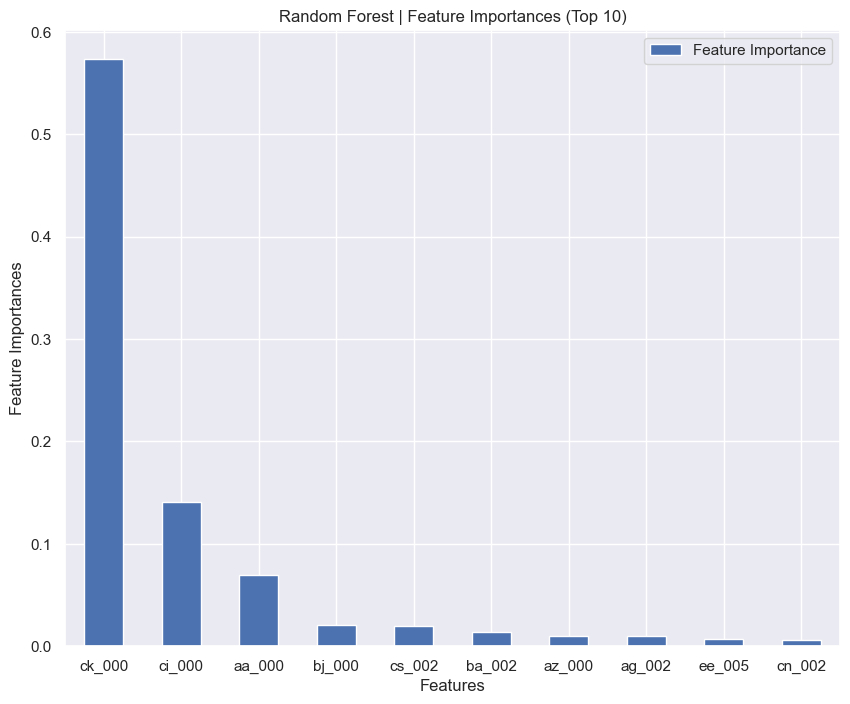

In [10]:
pd.DataFrame(zip(X_train.columns, pipe['rf_clf'].feature_importances_), columns=['Feature', 'Feature Importance'])\
    .sort_values(by='Feature Importance', ascending=False)[:10]\
    .plot(kind='bar', x='Feature', y='Feature Importance', figsize=(10, 8), title='Random Forest | Feature Importances (Top 10)', ylabel='Feature Importances', xlabel='Features', rot=0);

* ck_000 is, by far, the most significant variable. 

* If the data had not been anonymized, further analysis + domain knowledge could be applied to figure out why this is the case, and to drive improvements to the system (e.g. upgrade the sensor responsible for ck_000 data to improve either quality or frequency of the measurement)

* Comparing to the Logistic Regression Top 10 Coefficients from logistic_reg.ipynb, 4 out of 10 top features were the same between both models. However, the logistic regression coefficients for the top 10 features were much closer to each other.

### Misclassification Cost on Test Data

In [42]:
df_test = pd.read_csv(r'./data/aps_failure_test_set_data_only.csv')

X_test = df_test.drop('class', axis=1)
y_test = df_test['class']
y_pred = pipe.predict(X_test)

print('Misclassification Cost on Test Data: %i' % calc_misclassification_cost(y_test, y_pred))

Misclassification Cost on Test Data: 12970


In [43]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('Number of Type 1 Faults: %i' % fp)
print('Number of Type 2 Faults: %i' % fn)

Number of Type 1 Faults: 547
Number of Type 2 Faults: 15


* The Random Forest model, tuned with Bayesian Optimization, performed better than both the ComplementNB and Logistic Regression models.

* The Random Forest had more Type 1 faults than the Logistic Regression model, however, it had 7 less Type 2 faults (22 for LR model vs. 15 for the RF model)